This project is my 1st experience with Image segmentation problem. I hope that I did good job.
In this task we're going to build 2 models and solve **2 problems**:

1. The 1st one will be responsible for classification (whether patient has brain tumor or not). This model is build via transfer learning, exactly **ResNet50 with Fine tuning**. The results are impressive (**accuracy 0.989, recall 0.99 and precission 0.98**).
2. The 2nd model will detect location of brain tumor for those patients who has it. This model is build via **ResUnet architecture**, uses **Tversky** loss function and metric. Results of the model were great: **all rates have +-99%** (including recall and precission). In the end you can see final visialusations of model's results and usefull links.

This project is a part of course on Udemy.com.

## Mount drive and import libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/HealthcareAI/

/content/drive/My Drive/HealthcareAI


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from skimage import io
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from IPython.display import display
from tensorflow.keras import backend as K
import os
%matplotlib inline

## Explore dataset

In [ ]:
brain_df = pd.read_csv('data_mask.csv')

In [ ]:
brain_df.head()

,patient_id,image_path,mask_path,mask
0,TCGA_CS_5395_19981004,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif,TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_...,0
1,TCGA_CS_5395_19981004,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1.tif,TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_1_...,0
2,TCGA_CS_5395_19981004,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif,TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1_...,0
3,TCGA_CS_5395_19981004,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1.tif,TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_1_...,0
4,TCGA_CS_5395_19981004,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1.tif,TCGA_CS_5396_20010302/TCGA_CS_5396_20010302_1_...,0


In [ ]:
brain_df.isna().sum()

patient_id    0
image_path    0
mask_path     0
mask          0
dtype: int64

In [ ]:
brain_df.shape

(3929, 4)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


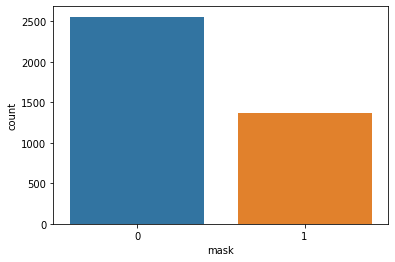

In [ ]:
sns.countplot(brain_df['mask'])
plt.show()
# we have ill persons almost twice less than healthy

In [ ]:
brain_df.mask_path[0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1_mask.tif'

In [ ]:
brain_df.image_path[0]

'TCGA_CS_5395_19981004/TCGA_CS_5395_19981004_1.tif'

In [ ]:
brain_df.mask_path[brain_df['mask'] == 1]

445     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_5_...
507     TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_5_...
551     TCGA_CS_4944_20010208/TCGA_CS_4944_20010208_6_...
555     TCGA_CS_5393_19990606/TCGA_CS_5393_19990606_6_...
617     TCGA_HT_7680_19970202/TCGA_HT_7680_19970202_6_...
                              ...                        
3785    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_56...
3795    TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_57...
3797    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_57...
3806    TCGA_FG_A60K_20040224/TCGA_FG_A60K_20040224_58...
3808    TCGA_HT_A61A_20000127/TCGA_HT_A61A_20000127_58...
Name: mask_path, Length: 1373, dtype: object

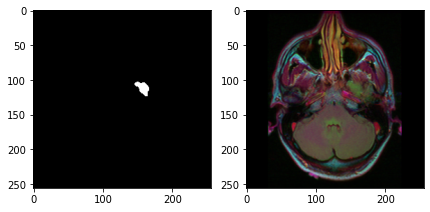

In [ ]:
# case when we have brain tumor
fig, axes = plt.subplots(1, 2, figsize=(7,7))
axes[0].imshow(cv2.imread(brain_df.mask_path[445]))
axes[1].imshow(cv2.imread(brain_df.image_path[445]))
plt.show()

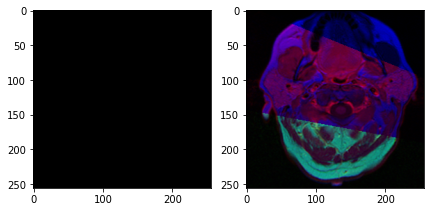

In [ ]:
# and case when patient is healthy
fig, axes = plt.subplots(1, 2, figsize=(7,7))
axes[0].imshow(cv2.imread(brain_df.mask_path[2]))
axes[1].imshow(cv2.imread(brain_df.image_path[2]))
plt.show()

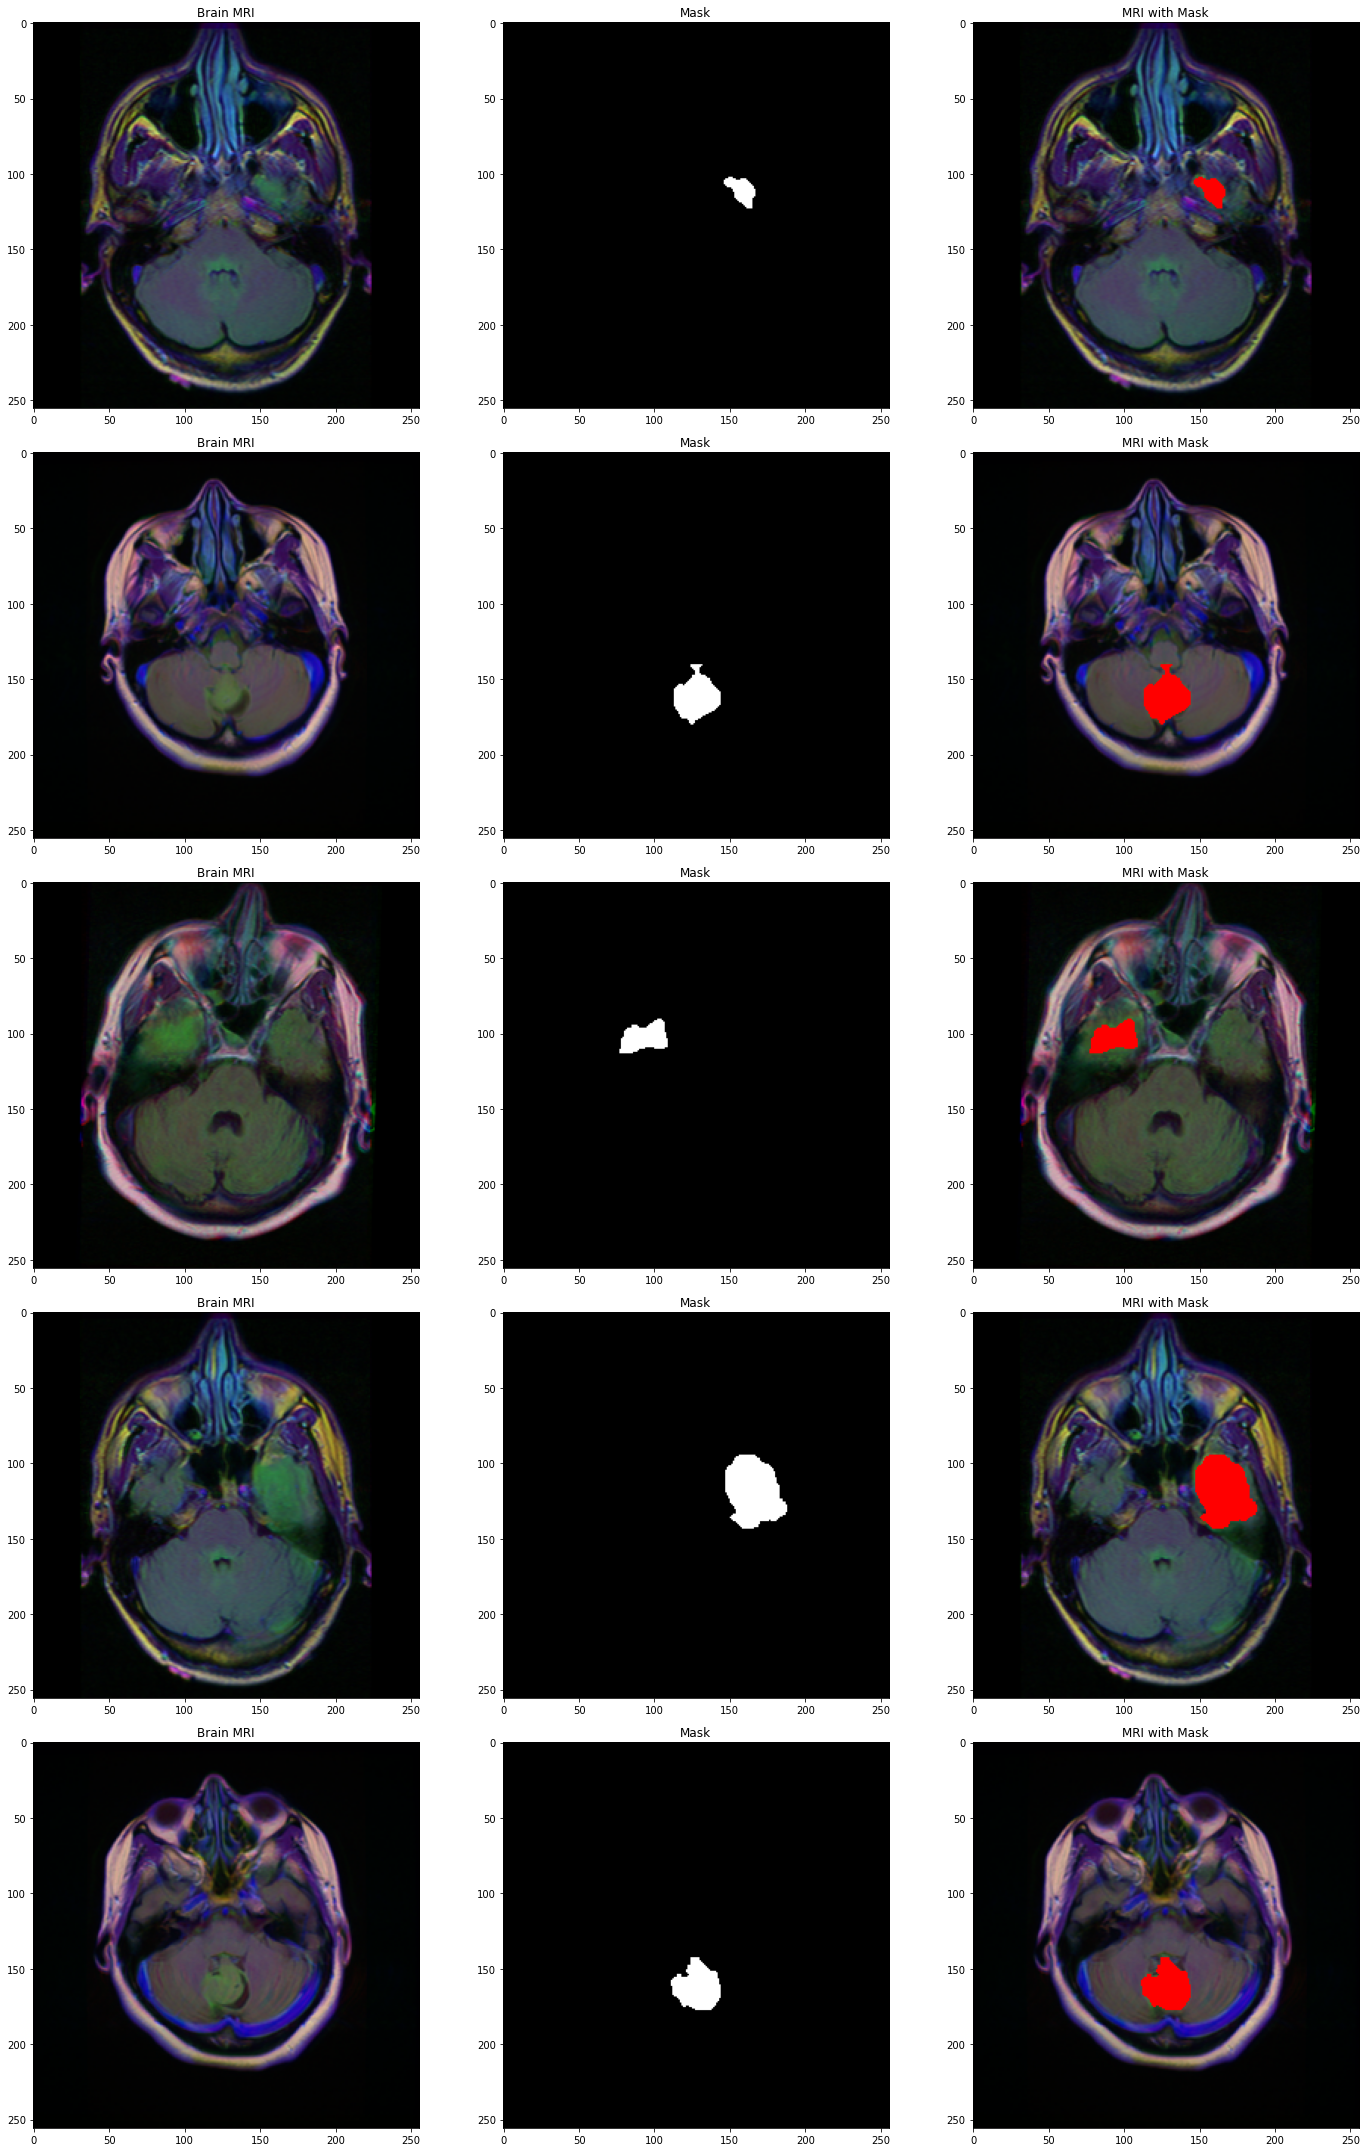

In [ ]:
count = 0
fig, axes = plt.subplots(5, 3, figsize = (20, 30))
for i in range(len(brain_df)):
  if brain_df['mask'][i] == 1 and count < 5:

    img = io.imread(brain_df.image_path[i])
    axes[count][0].set_title('Brain MRI')
    axes[count][0].imshow(img)

    mask = io.imread(brain_df.mask_path[i])
    axes[count][1].set_title('Mask')
    axes[count][1].imshow(mask, cmap='gray')
    
    img[mask == 255] = (255, 0, 0) # make brain tumor red on original brain MRI
    axes[count][2].set_title('MRI with Mask')
    axes[count][2].imshow(img)
    count+=1
fig.tight_layout()

## Model to detect if there's a brain tumor

In [ ]:
brain_df_train = brain_df.drop(columns = ['patient_id'])
brain_df_train.shape

(3929, 3)

In [ ]:
brain_df.info() 
# need to convert 'mask' column to str type, 
# otherwise Image data generator will give you an error, if you want to use 'categorical mode'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3929 entries, 0 to 3928
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   patient_id  3929 non-null   object
 1   image_path  3929 non-null   object
 2   mask_path   3929 non-null   object
 3   mask        3929 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 122.9+ KB


In [ ]:
brain_df_train['mask'] = brain_df_train['mask'].apply(lambda x: str(x))

In [ ]:
from keras_preprocessing.image import ImageDataGenerator
image_data_gen = ImageDataGenerator(rescale=1./255., validation_split = 0.15)
test_data_gen = ImageDataGenerator(rescale=1./255.)

In [ ]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(brain_df_train, test_size = 0.15)

In [ ]:
batch = 16

In [ ]:
train_gen = image_data_gen.flow_from_dataframe(dataframe=train,
                                               directory='/content/drive/My Drive/HealthcareAI',
                                               x_col='image_path', y_col='mask',
                                               subset='training',
                                               batch_size=batch,
                                               shuffle=True,
                                               class_mode='categorical',
                                               target_size=(256, 256))
val_gen = image_data_gen.flow_from_dataframe(dataframe=train,
                                               directory='/content/drive/My Drive/HealthcareAI',
                                               x_col='image_path', y_col='mask',
                                               subset='validation',
                                               batch_size=batch,
                                               shuffle=True,
                                               class_mode='categorical',
                                               target_size=(256, 256))
test_gen = test_data_gen.flow_from_dataframe(dataframe=test,
                                               directory='/content/drive/My Drive/HealthcareAI',
                                               x_col='image_path', y_col='mask',
                                               batch_size=batch,
                                               shuffle=False,
                                               class_mode='categorical',
                                               target_size=(256, 256))

Found 2839 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 590 validated image filenames belonging to 2 classes.


In [ ]:
resnet = ResNet50(include_top=False, input_tensor=Input((256, 256, 3)))
#resnet.summary()

I'll try 3 different approches: 


1.   Freeze all layers (call freeze_or_tune() func)
2.   Tune only conv4 and conv5 blocks
3.   Tune the whole net



In [ ]:
def freeze_or_tune(tune=True):
  if tune:
    resnet.trainable = True
  else:
    resnet.trainable = False

In [ ]:
# optional
freeze_or_tune(True)

In [ ]:
# for Fine tuning (not the whole resnet will be tuned)
for i in range(len(resnet.layers)):
  if resnet.layers[i].name.startswith('conv5') or resnet.layers[i].name.startswith('conv4') or resnet.layers[i].name.startswith('conv3'):
    resnet.layers[i].trainable = True
  else:
    resnet.layers[i].trainable = False

In [ ]:
# look at this table and make sure that necessary layers trainable or not
layers = [(layer, layer.name, layer.trainable) for layer in resnet.layers]
df = pd.DataFrame(layers, columns=['layer', 'name', 'is_trainable'])
df[df['is_trainable']==True]     

,layer,name,is_trainable
39,<tensorflow.python.keras.layers.convolutional....,conv3_block1_1_conv,True
40,<tensorflow.python.keras.layers.normalization_...,conv3_block1_1_bn,True
41,<tensorflow.python.keras.layers.core.Activatio...,conv3_block1_1_relu,True
42,<tensorflow.python.keras.layers.convolutional....,conv3_block1_2_conv,True
43,<tensorflow.python.keras.layers.normalization_...,conv3_block1_2_bn,True
...,...,...,...
170,<tensorflow.python.keras.layers.core.Activatio...,conv5_block3_2_relu,True
171,<tensorflow.python.keras.layers.convolutional....,conv5_block3_3_conv,True
172,<tensorflow.python.keras.layers.normalization_...,conv5_block3_3_bn,True
173,<tensorflow.python.keras.layers.merge.Add obje...,conv5_block3_add,True


In [ ]:
# build model
X = resnet.output
X = AveragePooling2D((4, 4))(X)
X = Flatten(name='flatten')(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
X = Dense(256, activation='relu')(X)
X = Dropout(0.3)(X)
output = Dense(2, activation='softmax')(X)
model = Model(inputs=resnet.input, outputs=output)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics= ['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
path_checkpoint = 'classifier-resnet-weights_fine_tuning_16b_345_3.hdf5'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_gen, steps_per_epoch=train_gen.n // batch, 
                    epochs=20, validation_data=val_gen, 
                    validation_steps=val_gen.n // batch, 
                    callbacks=[checkpoint, earlystopping])

In [ ]:
model_json = model.to_json()
with open('model_fine_tuning_16b_345_3.json', 'w') as json_file:
  json_file.write(model_json)

## Model evaluation

For a model with freeze layers accuracy was only **0.76**; with fine tuning (trainable were conv4 and conv5 blocks) and batch size 32 - **0.86**; with fine tuning (trainable were conv4 and conv5 blocks) and batch size 64 and 50 epoch - **0.94**; with fine tuning (trainable were conv3, conv4 and conv5 blocks) and batch size 16 - **0.989**; 

We can conclude next, that in our situation **recall is more significant** than precision, as we want to detect every patient with disease. **Thus, the model with 16 batch size and fine-tuned conv3, conv4 and conv5 blocks of ResNet50 is better.** In the next code **model 2** is the winner, both model 1 and model 2 have recall of 0.99, but 2nd model has higher f1-score 0.99 (in model 1 - 0.97).

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score

In [ ]:
test.shape

(590, 3)

In [ ]:
with open('model_fine_tuning_16b_345.json', 'r') as json_file:
  json_saved_model = json_file.read()
model1 = tf.keras.models.model_from_json(json_saved_model)
model1.load_weights('classifier-resnet-weights_fine_tuning_16b_345.hdf5')
model1.compile(loss ='categorical_crossentropy', optimizer=optimizers.Adam(0.0001), metrics= ['accuracy'])

preds1 = model1.predict(test_gen, steps=test_gen.n // batch, verbose=1)
preds1 = np.argmax(preds1, axis=1)
true = np.asarray(test['mask'][:len(preds1)], dtype='int32')
accuracy1 = accuracy_score(true, preds1)
accuracy1 # accuracy - 0.979

36/36 [==============================] - 2s 67ms/step


0.9791666666666666

In [ ]:
with open('model_fine_tuning_16b_345_2.json', 'r') as json_file:
  json_saved_model = json_file.read()
model2 = tf.keras.models.model_from_json(json_saved_model)
model2.load_weights('classifier-resnet-weights_fine_tuning_16b_345_2.hdf5')
model2.compile(loss ='categorical_crossentropy', optimizer=optimizers.Adam(0.0001), metrics= ['accuracy'])

preds2 = model2.predict(test_gen, steps=test_gen.n // batch, verbose=1)
preds2 = np.argmax(preds2, axis=1)
true = np.asarray(test['mask'][:len(preds2)], dtype='int32')

In [ ]:
accuracy2 = accuracy_score(true, preds2)
accuracy2 # accuracy - 0.984

0.984375

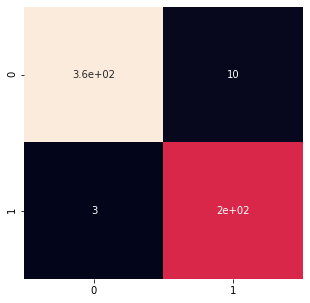

In [ ]:
cm = confusion_matrix(true, preds1)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True, cbar=False)

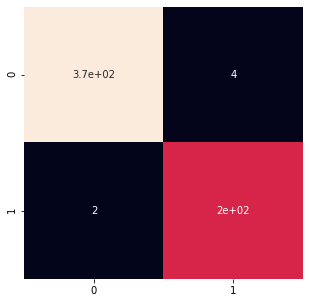

In [ ]:
cm = confusion_matrix(true, preds2)
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True, cbar=False)

In [ ]:
cl_report = classification_report(true, preds1, labels = [0,1])
print(cl_report)

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       374
           1       0.95      0.99      0.97       202

    accuracy                           0.98       576
   macro avg       0.97      0.98      0.98       576
weighted avg       0.98      0.98      0.98       576



In [ ]:
cl_report = classification_report(true, preds2, labels = [0,1])
print(cl_report)

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       374
           1       0.98      0.99      0.99       202

    accuracy                           0.99       576
   macro avg       0.99      0.99      0.99       576
weighted avg       0.99      0.99      0.99       576



In [ ]:
roc_auc_score(true, preds1), roc_auc_score(true, preds2) # almost the same

(0.9792052734685234, 0.9897019113676073)

In [ ]:
# best model
model2.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________

## Part 2. Detect location of brain tumor.

In [ ]:
brain_df_mask = brain_df[brain_df['mask'] == 1]

In [ ]:
brain_df_mask.shape

(1373, 4)

In [ ]:
X_train, X_val = train_test_split(brain_df_mask, test_size=0.15)
X_val, X_test = train_test_split(X_val, test_size=0.5)

In [ ]:
train_ids = list(X_train.image_path)
train_masks = list(X_train.mask_path)

val_ids = list(X_val.image_path)
val_masks = list(X_val.mask_path)

In [ ]:
from utilities import DataGenerator
# this generator was written by the author of course
train_gen = DataGenerator(train_ids,train_masks)
val_gen = DataGenerator(val_ids,val_masks)

In [ ]:
def res_block(X, f):
  X_shortcut = X
  X = Conv2D(filters=f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(filters=f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
  X = BatchNormalization()(X)

  X_shortcut = Conv2D(filters=f, kernel_size=(1,1), kernel_initializer='he_normal')(X_shortcut)
  X_shortcut = BatchNormalization()(X_shortcut)

  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)
  return X

In [ ]:
def upsample_concat(X, X_shortcut):
  X = UpSampling2D((2, 2))(X)
  X = Concatenate()([X, X_shortcut])
  return X

In [ ]:
# in order to understand architechture find links at the end of notebook
input_shape = (256, 256, 3)
X_input = Input(input_shape)

# Stage 1
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', 
               kernel_initializer='he_normal')(X_input)
conv1 = BatchNormalization()(conv1)
conv1 = Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', 
               kernel_initializer='he_normal')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D((2, 2))(conv1)

# Stage 2
conv2 = res_block(pool1, 32)
pool2 = MaxPooling2D((2, 2))(conv2)

# Stage 3
conv3 = res_block(pool2, 64)
pool3 = MaxPooling2D((2, 2))(conv3)

# Stage 4
conv4 = res_block(pool3, 128)
pool4 = MaxPooling2D((2, 2))(conv4)

# Stage 5 (Bottle Neck)
conv5 = res_block(pool4, 256)

# Stage 4
upsample1 = upsample_concat(conv5, conv4)
upsample1 = res_block(upsample1, 128)

# Stage 3
upsample2 = upsample_concat(upsample1, conv3)
upsample2 = res_block(upsample2, 64)

# Stage 2
upsample3 = upsample_concat(upsample2, conv2)
upsample3 = res_block(upsample3, 32)

# Stage 1
upsample4 = upsample_concat(upsample3, conv1)
upsample4 = res_block(upsample4, 16)

output = Conv2D(1, (1, 1), padding='same', activation='sigmoid')(upsample4)
model = Model(inputs=X_input, outputs=output)

In [ ]:
model.summary()

## Train and evaluate modell

"We need a custom loss function to train this ResUNet. So, we have used the loss function as it is from https://github.com/nabsabraham/focal-tversky-unet/blob/master/losses.py "

In [ ]:
# you can find these funcs in utility.py file, but my model has problems with them, so I rewrite them
def tversky(y_true, y_pred, smooth = 1e-6):
    y_pred = tf.cast(y_pred, tf.float64)
    y_true = tf.cast(y_true, tf.float64)
    y_true_pos = K.flatten(y_true)
    y_pred_pos = K.flatten(y_pred)
    true_pos = K.sum(y_true_pos * y_pred_pos)
    false_neg = K.sum(y_true_pos * (1-y_pred_pos))
    false_pos = K.sum((1-y_true_pos)*y_pred_pos)
    alpha = 0.7 # if alpha > 0.5 then more attention is paid to FN
    return (true_pos + smooth)/(true_pos + alpha*false_neg + (1-alpha)*false_pos + smooth)

def tversky_loss(y_true, y_pred):
    return 1 - tversky(y_true,y_pred)

def focal_tversky(y_true,y_pred):
    y_pred = tf.cast(y_pred, tf.float64)
    y_true = tf.cast(y_true, tf.float64)
    pt_1 = tversky(y_true, y_pred)
    gamma = 0.75
    return K.pow((1-pt_1), gamma)

In [ ]:
model.compile(optimizer=optimizers.Adam(lr=0.05, epsilon=0.1), loss=focal_tversky, metrics=[tversky])

In [ ]:
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
path_checkpoint = 'res-unet-weights2.hdf5'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_gen, epochs=20, validation_data=val_gen, callbacks = [checkpoint, earlystopping])

In [ ]:
model_json = model.to_json()
with open('res-unet-model2.json', 'w') as json_file:
  json_file.write(model_json)

Predcition function which takes dataframe containing ImageID as Input and perform 2 type of prediction on the image. Initially, image is passed through the classification network which predicts whether the image has defect or not, if the model is sure that the image has no defect, then the image is labeled as no-defect, if the model is not sure, it passes the image to the segmentation network, it again checks if the image has defect or not, if it has defect, then the type and location of defect is found.

In [ ]:
# this func also is in utilities.py, but I write for more interpretability 
def prediction(test, first_model, seg_model):
  dir = './'
  mask, image_ids, has_mask = [], [], []
  for p in test.image_path:
    path = dir + str(p)
    img = io.imread(path)
    img = img * 1./255.
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img = img.reshape((1, 256, 256, 3))
    preds = first_model.predict(img)

    if np.argmax(preds, axis=1) == 0:
      mask.append('No mask')
      image_ids.append(p)
      has_mask.append(0)
      continue
    # if there is brain tumor
    img = io.imread(path)
    img = cv2.resize(img, (256, 256))
    img = np.array(img, dtype=np.float64)
    img -= img.mean()
    img /= img.std()
    img = img.reshape((1, 256, 256, 3))

    pred_mask = seg_model.predict(img)
    # if sum of pixels == 0 - it means we have no white segment on image
    if np.sum(pred_mask.round().astype(int)) > 0:
      mask.append(pred_mask)
      image_ids.append(p)
      has_mask.append(1)
    else:
      mask.append('No mask')
      image_ids.append(p)
      has_mask.append(0)
  return image_ids, mask, has_mask

In [ ]:
with open('res-unet-model1.json', 'r') as json_model:
  json_saved_model = json_model.read()

model_seg1 = tf.keras.models.model_from_json(json_saved_model)
model_seg1.load_weights('res-unet-weights1.hdf5')
model_seg1.compile(optimizer=optimizers.Adam(lr=0.05, epsilon=0.1), loss=focal_tversky, metrics=[tversky])

In [ ]:
with open('res-unet-model2.json', 'r') as json_model:
  json_saved_model = json_model.read()

model_seg2 = tf.keras.models.model_from_json(json_saved_model)
model_seg2.load_weights('res-unet-weights2.hdf5')
model_seg2.compile(optimizer=optimizers.Adam(lr=0.05, epsilon=0.1), loss=focal_tversky, metrics=[tversky])

**Prediction func** returns ImageId, predicted mask and whether there is mask (or brain tumor) or not.

In [ ]:
image_id, mask, has_mask = prediction(test, model2, model_seg1) # model2 - best model from the previous part

In [ ]:
df1 = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df1.head(3)

In [ ]:
df1 = test.merge(df1, on='image_path')
df1.has_mask = df1.has_mask.astype(str) # as 'mask' column was in df test of type str
df1.head(3)

In [ ]:
cm = confusion_matrix(df1['mask'], df1['has_mask'])
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True, cbar=False) 

In [ ]:
image_id, mask, has_mask = prediction(test, model2, model_seg2)
df2 = pd.DataFrame({'image_path': image_id,'predicted_mask': mask,'has_mask': has_mask})
df2 = test.merge(df2, on='image_path')
df2.has_mask = df2.has_mask.astype(str) # as 'mask' column was in df test of type str
df2.head(3)

In [ ]:
cm = confusion_matrix(df2['mask'], df2['has_mask'])
plt.figure(figsize = (5,5))
sns.heatmap(cm, annot=True, cbar=False) # better - has lower FN

In [ ]:
print(classification_report(df2['mask'], df2['has_mask']))

So 2nd is a little bit better. It was trained on 20 epoch and 1st model - 10 epoch.

## Visualise results

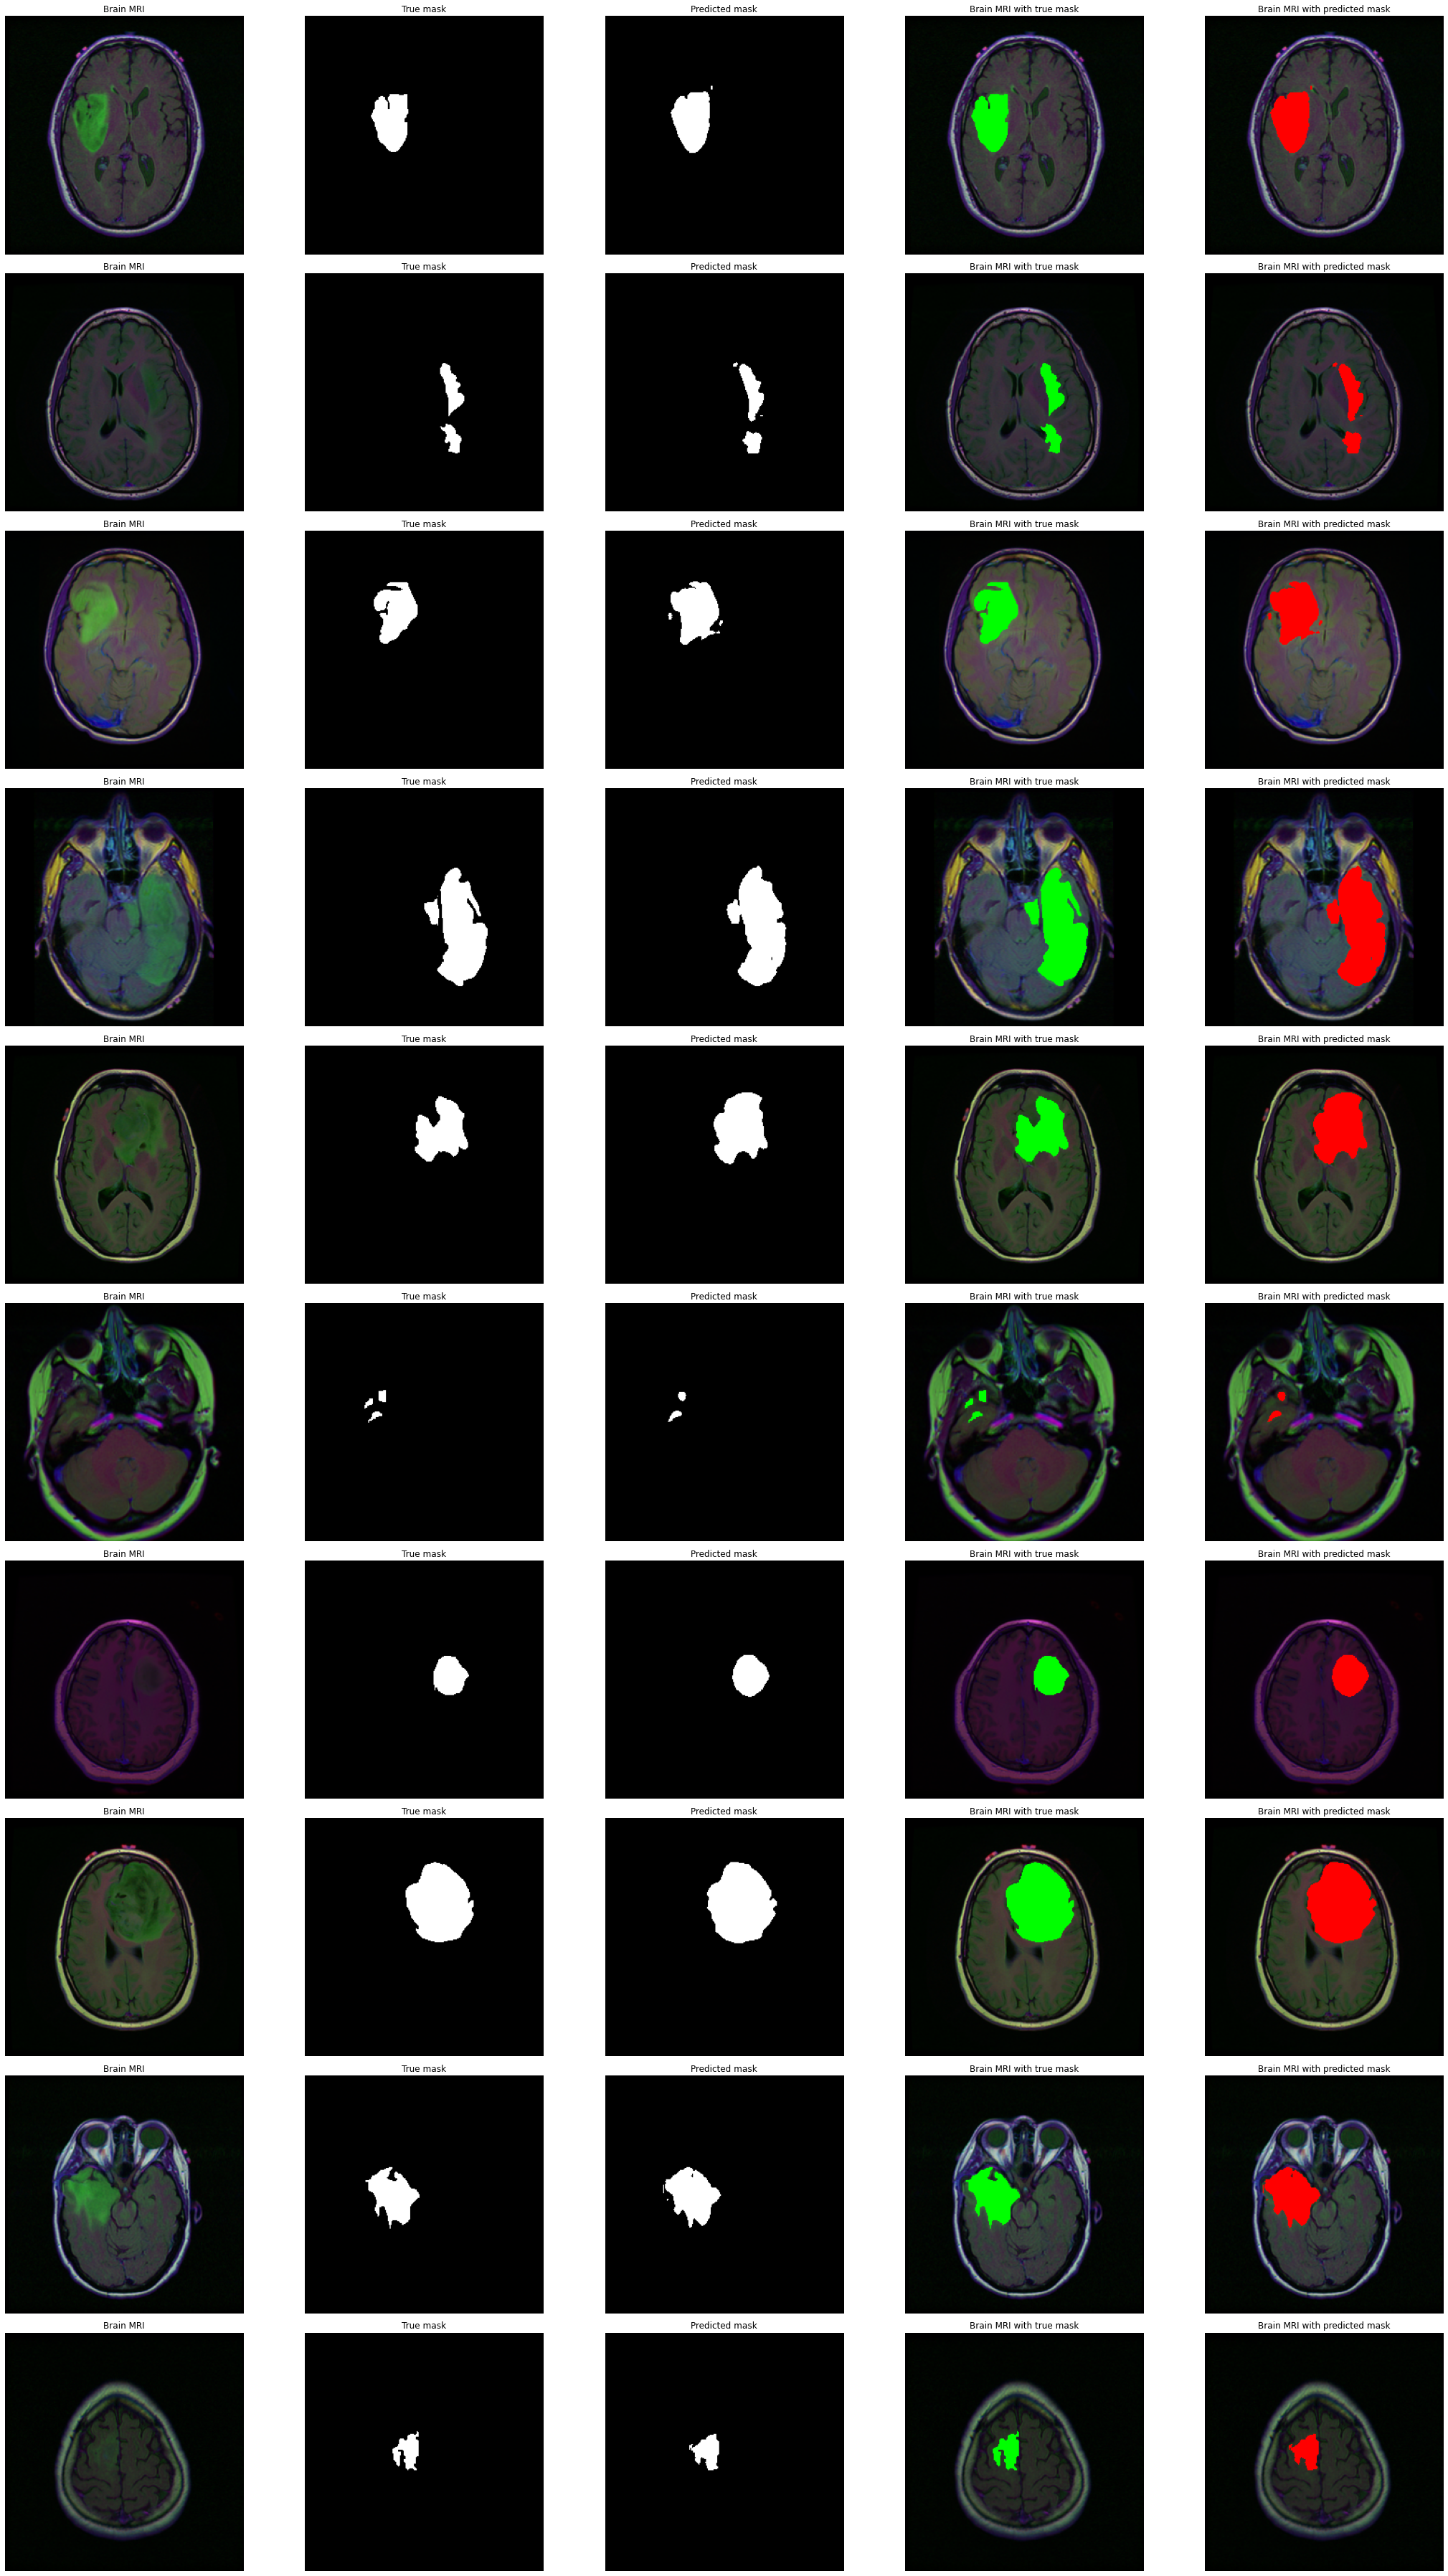

In [ ]:
count = 0 
fig, axes = plt.subplots(10, 5, figsize=(30, 50))
for i in range(df2.shape[0]):
  if df2['has_mask'][i] == '1' and count < 10:
    img = io.imread(df2.image_path[i])
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[count][0].imshow(img)
    axes[count][0].set_title('Brain MRI')

    mask = io.imread(df2.mask_path[i])
    axes[count][1].imshow(mask, cmap='gray')
    axes[count][1].set_title('True mask')

    pred_mask = df2.predicted_mask[i].squeeze().round()
    axes[count][2].imshow(pred_mask, cmap='gray')
    axes[count][2].set_title('Predicted mask')

    img_ = img.copy()
    img_[mask == 255] = (0, 255, 0)
    axes[count][3].imshow(img_)
    axes[count][3].set_title('Brain MRI with true mask')

    img_ = img.copy()
    img_[pred_mask == 1] = (255, 0, 0)
    axes[count][4].imshow(img_)
    axes[count][4].set_title('Brain MRI with predicted mask')

    axes[count][0].axis('off')
    axes[count][1].axis('off')
    axes[count][2].axis('off')
    axes[count][3].axis('off')
    axes[count][4].axis('off')

    count += 1
plt.tight_layout()

Now let's look at those MRIs where our model wasn't right

In [ ]:
# False negative examples
df_FN = df2[df2['has_mask'] < df2['mask']]
df_FN.reset_index(inplace=True)
df_FN

,index,image_path,mask_path,mask,predicted_mask,has_mask
0,169,TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_24...,TCGA_HT_7473_19970826/TCGA_HT_7473_19970826_24...,1,No mask,0
1,337,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_31...,TCGA_FG_7637_20000922/TCGA_FG_7637_20000922_31...,1,No mask,0
2,386,TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_32...,TCGA_DU_8164_19970111/TCGA_DU_8164_19970111_32...,1,No mask,0


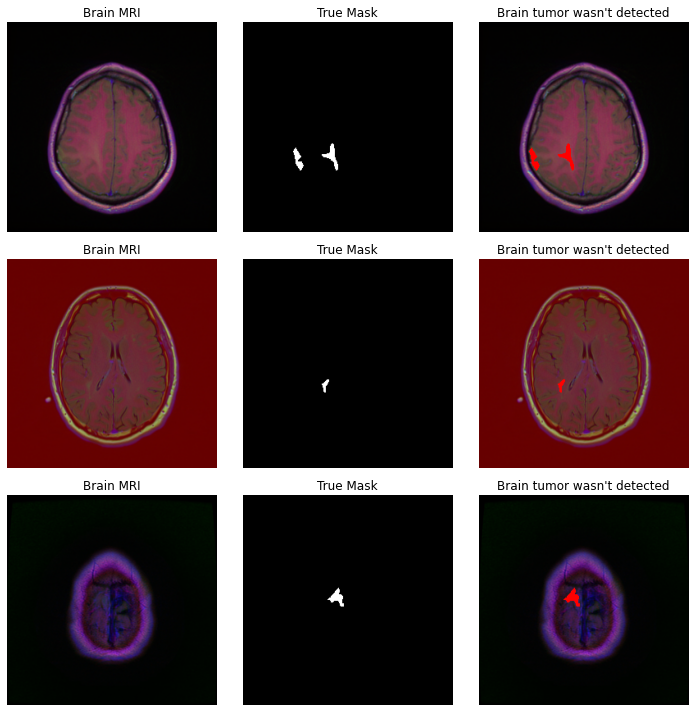

In [ ]:
# change the size of rows/cols if you have another df with FN/FP
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
  img = io.imread(df_FN.image_path[i])
  axes[i][0].imshow(img)
  axes[i][0].set_title('Brain MRI')

  mask = io.imread(df_FN.mask_path[i])
  axes[i][1].imshow(mask, cmap='gray')
  axes[i][1].set_title('True Mask')

  img[mask == 255] = (255, 0, 0)
  axes[i][2].imshow(img)
  axes[i][2].set_title('Brain tumor wasn\'t detected')

  axes[i][0].axis('off')
  axes[i][1].axis('off')
  axes[i][2].axis('off')
plt.tight_layout()
# as you can see these brain tumors are really so small

In [ ]:
# False positive examples
df_FP = df2[df2['has_mask'] > df2['mask']]
df_FP.reset_index(inplace=True)
df_FP

,index,image_path,mask_path,mask,predicted_mask,has_mask
0,141,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_18...,TCGA_DU_6407_19860514/TCGA_DU_6407_19860514_18...,0,"[[[[7.5540665e-06], [6.2161907e-06], [5.566403...",1
1,331,TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_9.tif,TCGA_HT_7882_19970125/TCGA_HT_7882_19970125_9_...,0,"[[[[7.45809e-06], [4.29099e-06], [2.343456e-06...",1
2,573,TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_10...,TCGA_HT_A5RC_19990831/TCGA_HT_A5RC_19990831_10...,0,"[[[[5.1980487e-06], [4.7671574e-06], [6.442735...",1


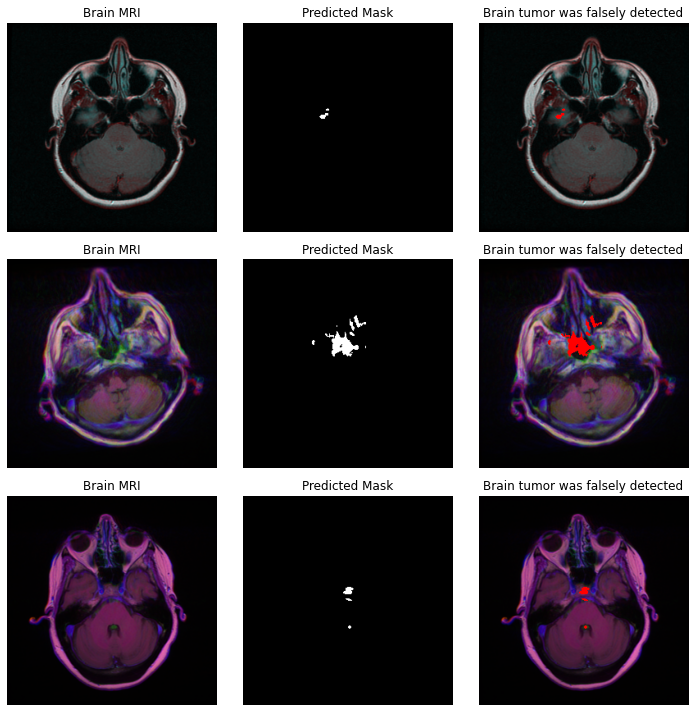

In [ ]:
# change the size of rows/cols if you have another df with FN/FP
fig, axes = plt.subplots(3, 3, figsize=(10,10))
for i in range(3):
  img = io.imread(df_FP.image_path[i])
  axes[i][0].imshow(img)
  axes[i][0].set_title('Brain MRI')

  mask = df_FP.predicted_mask[i].squeeze().round()
  axes[i][1].imshow(mask, cmap='gray')
  axes[i][1].set_title('Predicted Mask')

  img[mask == 1] = (255, 0, 0)
  axes[i][2].imshow(img)
  axes[i][2].set_title('Brain tumor was falsely detected')

  axes[i][0].axis('off')
  axes[i][1].axis('off')
  axes[i][2].axis('off')
plt.tight_layout()

Our results are great: we have accurate models, know about ResUNet architecture and image segmentation!

## Links

About Tversky loss function:

https://towardsdatascience.com/dealing-with-class-imbalanced-image-datasets-1cbd17de76b5
https://arxiv.org/abs/1706.05721

ResUNet:

https://towardsdatascience.com/introduction-to-u-net-and-res-net-for-image-segmentation-9afcb432ee2f

Transfer learning:

https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a
